In [73]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [74]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Studio algoritmi per trovare i prezzi di riferimento per il calcolo delle variazioni di prezzo

In [75]:
# Funzione per generare prezzi casuali basati su una distribuzione delle variazioni
def genera_prezzi(num_giorni, distribuzione_variazioni):
    np.random.seed(0)  # Per riproducibilità
    prezzi = [100]  # Prezzo iniziale
    variazioni = np.random.choice(list(distribuzione_variazioni.keys()), 
                                  size=num_giorni-1, 
                                  p=list(distribuzione_variazioni.values()))
    
    for variazione in variazioni:
        prezzi.append(prezzi[-1] * (1 + variazione))
    
    return pd.DataFrame({'Timestamp': pd.date_range(start='2023-01-01', periods=num_giorni, freq='D'), 
                         'Price': prezzi})

In [76]:
# Distribuzione delle variazioni (esempio)
distribuzione_variazioni = {
    -0.05: 0.1,
    -0.02: 0.2,
    -0.01: 0.2,
    0.01: 0.2,
    0.02: 0.2,
    0.05: 0.1
}

# Genera prezzi
num_giorni = 100
dati = genera_prezzi(num_giorni, distribuzione_variazioni)

# Calcola variazioni
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

# Parametri
soglia_calcolo_variazioni_discesa = 0.05
soglia_calcolo_variazioni_salita = 0.05

prezzi_riferimento_discesa = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente < 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if variazione_cumulata - 1 >= soglia_calcolo_variazioni_discesa and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_discesa.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True

prezzi_riferimento_salita = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente > 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if 1 - variazione_cumulata >= soglia_calcolo_variazioni_salita and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_salita.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True




# Creazione del grafico con Plotly
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(x=dati['Timestamp'], y=dati['Price'], 
                         mode='lines', name='Prezzi',
                         line=dict(color='blue', width=2)))

# Aggiungi punti di riferimento discesa (in verde)
for timestamp, prezzo_riferimento in prezzi_riferimento_discesa:
    fig.add_trace(go.Scatter(
        x=[timestamp], y=[prezzo_riferimento],
        mode='markers+text', name='Riferimento Discesa',
        marker=dict(color='green', size=10),
        text=[f'{prezzo_riferimento:.2f}'],
        textposition='top center',
        hoverinfo='text+name'  # Mostra testo e nome al passaggio del mouse
    ))

# Aggiungi punti di riferimento salita (in rosso)
for timestamp, prezzo_riferimento in prezzi_riferimento_salita:
    fig.add_trace(go.Scatter(
        x=[timestamp], y=[prezzo_riferimento],
        mode='markers+text', name='Riferimento Salita',
        marker=dict(color='red', size=10),
        text=[f'{prezzo_riferimento:.2f}'],
        textposition='top center',
        hoverinfo='text+name'  # Mostra testo e nome al passaggio del mouse
    ))

# Configurazione del layout del grafico
fig.update_layout(
    title='Prezzi generati con punti di riferimento per le discese (in verde) e per le salite (in rosso)',
    xaxis_title='Data',
    yaxis_title='Prezzo',
    hovermode='closest',
    template='plotly_white',
    width=1600,
    height=7/10 * 1600,
    showlegend=False,
    # legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    
    # Aggiungi il range slider per l'asse X
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Mostra il grafico
fig.show()

In [77]:
dati[:20]

,Timestamp,Price,Variazione
0,2023-01-01,100.000000,NaN
1,2023-01-02,101.000000,1.01
2,2023-01-03,103.020000,1.02
3,2023-01-04,104.050200,1.01
4,2023-01-05,105.090702,1.01
5,2023-01-06,104.039795,0.99
6,2023-01-07,105.080193,1.01
7,2023-01-08,104.029391,0.99
8,2023-01-09,106.109979,1.02
9,2023-01-10,111.415478,1.05


## Lettura dati Bitcoin

In [78]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [79]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [80]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
data_inizio = '2021-02-01'
data_fine = '2021-07-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-02-01,27790.582031
1,2021-02-02,29501.521484
2,2021-02-03,31119.447266
3,2021-02-04,30859.554688
4,2021-02-05,31658.248047
...,...,...
146,2021-06-27,29013.742188
147,2021-06-28,28866.302734
148,2021-06-29,30139.980469
149,2021-06-30,29555.054688


In [81]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

In [82]:
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

### Eventuale cambio dati

In [83]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [84]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price,Variazione
0,2021-02-01,27790.582031,NaN
1,2021-02-02,29501.521484,1.061565
2,2021-02-03,31119.447266,1.054842
3,2021-02-04,30859.554688,0.991649
4,2021-02-05,31658.248047,1.025882
...,...,...,...
146,2021-06-27,29013.742188,1.075958
147,2021-06-28,28866.302734,0.994918
148,2021-06-29,30139.980469,1.044123
149,2021-06-30,29555.054688,0.980593


## Algoritmo

In [85]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# def rif_discesa_sbagliato(dati, soglia_calcolo_variazioni_discesa):
#     # Cerca il prezzo di riferimento
#     prezzo_riferimento = None
#     variazione_cumulata = 1
#     cont = 0
#     for j in range(len(dati), 0, -1):
#         variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
#         if pd.isna(variazione_giorno_precedente):
#             continue
#         if variazione_giorno_precedente < 1:
#             variazione_cumulata = 1
#             cont = 0
#         else:
#             variazione_cumulata *= variazione_giorno_precedente
#             if variazione_cumulata != variazione_giorno_precedente:
#                 cont += 1
#             if variazione_cumulata - 1 >= soglia_calcolo_variazioni_discesa:
#                 prezzo_riferimento = dati['Price'].iloc[j+cont-1]
#                 timestamp_riferimento = dati['Timestamp'].iloc[j+cont-1]
#                 break
#     if prezzo_riferimento is None:
#         prezzo_riferimento = dati['Price'].iloc[0]
#         timestamp_riferimento = dati['Timestamp'].iloc[0]  # Usa il primo prezzo disponibile se nessun riferimento è trovato
#     return timestamp_riferimento, prezzo_riferimento

# def rif_salita_sbagliato(dati, soglia_calcolo_variazioni_salita):
#     # Cerca il prezzo di riferimento
#     prezzo_riferimento = None
#     variazione_cumulata = 1
#     cont = 0
#     for j in range(len(dati), 0, -1):
#         variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
#         if pd.isna(variazione_giorno_precedente):
#             continue
#         if variazione_giorno_precedente > 1:
#             variazione_cumulata = 1
#             cont = 0
#         else:
#             variazione_cumulata *= variazione_giorno_precedente
#             if variazione_cumulata != variazione_giorno_precedente:
#                 cont += 1
#             if 1 - variazione_cumulata >= soglia_calcolo_variazioni_salita:
#                 prezzo_riferimento = dati['Price'].iloc[j+cont-1]
#                 timestamp_riferimento = dati['Timestamp'].iloc[j+cont-1]
#                 break
#     if prezzo_riferimento is None:
#         prezzo_riferimento = dati['Price'].iloc[0]
#         timestamp_riferimento = dati['Timestamp'].iloc[0]  # Usa il primo prezzo disponibile se nessun riferimento è trovato
#     return timestamp_riferimento, prezzo_riferimento


def calcola_percentuale(variazione, coefficienti, A, B):
    if isinstance(coefficienti, list):
        # Se coefficienti è una lista, esegue la somma ponderata delle variazioni
        return min(max(sum([c * variazione ** i for i, c in enumerate(coefficienti)]), 0), 1)
    
    elif isinstance(coefficienti, str) and coefficienti != 'custom_exp':
        # Se coefficienti è una stringa, interpreta la stringa come una formula matematica
        # Sostituisci 'x' con il valore di variazione
        formula = coefficienti.replace('x', str(variazione))
        # Usa eval per calcolare il risultato
        try:
            risultato = eval(formula)
        except Exception as e:
            raise ValueError(f"Errore nell'interpretazione della formula: {e}")
        return min(max(risultato, 0), 1)
    
    elif coefficienti == 'custom_exp':
        return eval(f'variazione ** {A} / ({B} + (1 - {B}) * variazione ** {A})')
    
    else:
        raise TypeError("Il parametro 'coefficienti' deve essere una lista, una stringa o 'custom_exp'.")

In [86]:
# Define the function
def plot_custom_exp(A, B):
    # Generate a range of x values (variazione)
    variazione = np.linspace(0, 1, 500)
    
    # Calculate the function's values
    # y = variazione ** A / (B + (1 - B) * variazione ** A)
    
    # Plot the function
    plt.figure(figsize=(10, 6))
    plt.plot(variazione, calcola_percentuale(variazione, 'custom_exp', A, B), label=f'A={A}, B={B}')
    plt.xlabel('Variazione')
    plt.ylabel('Funzione')
    plt.title(f'Grafico della funzione')
    plt.legend()
    plt.grid()
    plt.show()

In [87]:
# Parametri della strategia
inverti_riferimento_acquisto = True # Se è True, la variazione percentuale viene calcolata "dall'alto in basso" (ad esempio, se il prezzo passa da 80 a 40 la variazione % è considerata del -50%); se è False, la variazione percentuale viene calcolata "dal basso all'alto" (ad esempio, se il prezzo passa da 80 a 40 la variazione % è considerata del +100% perchè da 40 a 80 c'è il 100%); la percentuale di acquisto sarà poi una funzione del modulo di questa variazione % attraverso la function calcola_percentuale
inverti_riferimento_vendita = True # Se è True, la variazione percentuale viene calcolata "dal basso all'alto" (ad esempio, se il prezzo passa da 70 a 140 la variazione % è considerata del +100%); se è False, la variazione percentuale viene calcolata "dall'alto al basso" (ad esempio, se il prezzo passa da 70 a 140 la variazione % è considerata del -50% perchè da 140 a 70 c'è il -50%); la percentuale di vendita sarà poi una funzione del modulo di questa variazione % attraverso la function calcola_percentuale
acquisto_rispetto_liquidità_iniziale = False
vendita_rispetto_massimo_btc_posseduti = True
compra_pure = False
vendi_pure = False
soglia_vendita = 0 # La vendita avviene solo se il prezzo è superiore almeno di questa percentuale rispetto al prezzo medio pesato degli ultimi acquisti consecutivi, dove i pesi sono gli euro spesi
A_a = 10 # Scegliere un numero > 0, anche se per una curva convessa conviene > 1
B_a = 0.001 # Scegliere un numero > 0
A_v = 10 # Scegliere un numero > 0, anche se per una curva convessa conviene > 1
B_v = 0.001 # Scegliere un numero > 0
coefficienti_acquisto = 'custom_exp' # Scegliere se mandare una lista che rappresenta i coefficienti di un polinomio, una stringa con una funzione in particolare scritta in Python, oppure custom_exp per l'esponenziale personalizzato con i parametri A e B
coefficienti_vendita =  'custom_exp' # Scegliere se mandare una lista che rappresenta i coefficienti di un polinomio, una stringa con una funzione in particolare scritta in Python, oppure custom_exp per l'esponenziale personalizzato con i parametri A e B
compra_solo_in_discesa = False
vendi_solo_in_salita = False
soglia_acquisto_rispetto_riferimento = 0 # L'acquisto avviene solo se il prezzo è sceso almeno di questa percentuale rispetto al prezzo_riferimento_discesa
soglia_vendita_rispetto_riferimento = 0 # La vendita avviene solo se il prezzo è salito almeno di questa percentuale rispetto al prezzo_riferimento_salita
# Parametri per le soglie
soglia_calcolo_variazioni_discesa = 0.05
soglia_calcolo_variazioni_salita = 0.05

perc_relativa = True # Se è False, la percentuale di variazione dei prezzi viene calcolata in senso assoluto (ad esempio, se il prezzo è 50€ e cala del 10% diventa 45€) sia per variazioni positive che per variazioni negative; se è True: se il prezzo_riferimento corrente è prezzo_riferimento_discesa, guardo quanto è sceso il prezzo relativamente al minimo degli ultimi finestra_minimo giorni  (ad esempio, se prezzo_riferimento_discesa era 80€, oggi è 70€ e il minimo è 50€, un calo del 100% sarebbe andato da 80€ a 50€, e quindi in proporzione un calo da 80€ a 70€ corrisponde a un -33.3%), mentre se il prezzo di riferimento è prezzo_riferimento_salita, guardo quanto è salito relativamente al massimo degli ultimi finestra_massimo giorni (ad esempio, se prezzo_riferimento_salita era 20€, quello di oggi è 50€ e il massimo è 90€, la salita relativa in percntuale è 3/7 ~ 42.9%); notare che se perc_relativa è True, sono indifferenti i valori di inverti_riferimento_acquisto nel caso di una discesa e inverti_riferimento_vendita nel caso di una salita, mentre se è False sono ovviamente indifferenti il valore di finestra_minimo e di finestra_massimo
finestra_minimo = 30 # Finestra per calcolare il minimo, compreso il giorno attuale
finestra_massimo = 30 # Finestra per calcolare il massimo, compreso il giorno attuale
nuovi_min_all_in = True # Utile solo se perc_relativa è True, altrimenti è come se non ci fosse: se è False, evita di acquistare il 100% se il prezzo attuale diventa il nuovo minimo, e in quel caso invece acquista come se perc_relativa fosse False (guardando quindi anche inverti_riferimento_acquisto e agendo di conseguenza); se è True, in caso di nuovi minimi acquista subito con il 100% di liquidità appena il prezzo diventa lui stesso il nuovo minimo degli ultimi finestra_minimo giorni
nuovi_max_all_in = True # Analogo di nuovi_min_all_in ma per il massimo (evita di vendere il 100%)

soglia_acquisti_vicini = 0.05 # Se è 0, è come se questa variabile non esistesse perchè rimane tutto come prima; se è > 0, un acquisto avviene solo se il prezzo attuale è almeno di questa soglia percentuale sopra l'ultimo prezzo di acquisto (ammesso che ci sia un acquisto precedente, e solo se non ci sono state delle vendite tra il giorno di quell'acquisto e oggi): ad esempio, se il prezzo dell'ultimo acquisto era 50€ e questa soglia è 5%, l'eventuale acquisto di oggi avviene solo se il prezzo è sopra 52.5 o sotto 47.5
soglia_vendite_vicine = 0.05 # Analogo di soglia_acquisti_vicini, ma con le vendite



# Parametri iniziali
liquidità_iniziale = 0  # Euro iniziali
bitcoin_iniziali = 0.02478146
liquidità = liquidità_iniziale
bitcoin = bitcoin_iniziali
valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

# Calcolo variazioni giornaliere
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

# Inizializza la lista delle transazioni
df_transazioni = pd.DataFrame(columns=['data', 'prezzo', 'variazione_giornaliera_prezzo_percentuale', 'timestamp_riferimento_discesa', 'prezzo_riferimento_discesa', 'variazione_rispetto_riferimento_discesa', 'timestamp_riferimento_salita', 'prezzo_riferimento_salita', 'variazione_rispetto_riferimento_salita', 'azione', 'Percentuale Liquidità Usata', 'Percentuale Bitcoin Usata', 'Percentuale Liquidità Usata rispetto riferimento', 'Percentuale Bitcoin Usata rispetto riferimento', 'quantità_euro', 'Bitcoin Acquistati/Venduti', 'Liquidità', 'Bitcoin', 'valore_totale_portafoglio'])

# Variabili per tenere traccia degli acquisti consecutivi
acquisti_consecutivi = []
quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

liquidità_iniziale_in_btc = liquidità_iniziale / dati['Price'].iloc[0]

ultimo_prezzo_acquisto = None
ultimo_prezzo_vendita = None
ultima_azione = None
azione = None


# Simulazione del trading giorno per giorno
for i in range(1, len(dati)):
    data_odierna = dati['Timestamp'].iloc[i]
    prezzo_attuale = dati['Price'].iloc[i]
    variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100
    if perc_relativa:
        if finestra_minimo <= i:
            minimo_ultimi_giorni = np.min(dati['Price'].iloc[i-finestra_minimo:i+1])

        else:
            minimo_ultimi_giorni = np.min(dati['Price'].iloc[:i+1])

        if finestra_massimo <= i:
            massimo_ultimi_giorni = np.max(dati['Price'].iloc[i-finestra_massimo:i+1])

        else:
            massimo_ultimi_giorni = np.max(dati['Price'].iloc[:i+1])
    
    # Calcola i prezzi di riferimento discesa e salita
    timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
    timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)
    # timestamp_riferimento_discesa, prezzo_riferimento_discesa = rif_discesa_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_discesa)
    # timestamp_riferimento_salita, prezzo_riferimento_salita = rif_salita_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_salita)

    # Scegli il prezzo di riferimento più recente (se esiste)
    prezzo_riferimento = None
    if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
        if timestamp_riferimento_discesa > timestamp_riferimento_salita:
            prezzo_riferimento = prezzo_riferimento_discesa
            tipo_riferimento = 'discesa'
        else:
            prezzo_riferimento = prezzo_riferimento_salita
            tipo_riferimento = 'salita'
    elif prezzo_riferimento_discesa is not None:
        prezzo_riferimento = prezzo_riferimento_discesa
        tipo_riferimento = 'discesa'
    elif prezzo_riferimento_salita is not None:
        prezzo_riferimento = prezzo_riferimento_salita
        tipo_riferimento = 'salita'

    # Se nessun riferimento è disponibile, passa al giorno successivo
    if prezzo_riferimento is None:
        continue

    # Variabili per tracciare l'azione e la transazione
    azione = '-'
    percentuale_liquidità_usata = 0
    percentuale_bitcoin_usata = 0
    percentuale_liquidità_usata_rispetto_rif = 0
    percentuale_bitcoin_usata_rispetto_rif = 0
    euro_spesi_o_ricavati = 0
    bitcoin_acquistati_o_venduti = 0

    # Logica di acquisto o vendita in base al riferimento più recente
    if tipo_riferimento == 'discesa':  # Logica di acquisto
        if not perc_relativa:
            if inverti_riferimento_acquisto:
                variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
            else:
                variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
        else:
            den = prezzo_riferimento_discesa - minimo_ultimi_giorni
            if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il minimo sia superiore all'ultimo prezzo_riferimento_discesa salvato
                num = prezzo_riferimento_discesa - prezzo_attuale
                variazione_percentuale = num / den
                if not nuovi_min_all_in and variazione_percentuale == 1:
                    if inverti_riferimento_acquisto:
                        variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
                    else:
                        variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
            else:
                variazione_percentuale = 0


        percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
        liquidità_da_usare = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
        euro_da_spendere = liquidità_da_usare * percentuale_acquisto

        if euro_da_spendere > liquidità:
            if compra_pure:
                euro_da_spendere = liquidità  # Usa tutto
            else:
                euro_da_spendere = 0  # Non fare niente

        if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento) and (soglia_acquisti_vicini > 0 and ultimo_prezzo_acquisto is not None and ultima_azione == 'Acquisto' and abs(prezzo_attuale - ultimo_prezzo_acquisto) >= soglia_acquisti_vicini * ultimo_prezzo_acquisto or soglia_acquisti_vicini == 0 or ultima_azione is None):
            percentuale_liquidità_usata = euro_da_spendere / liquidità
            bitcoin_acquistati = euro_da_spendere / prezzo_attuale
            liquidità -= euro_da_spendere
            bitcoin += bitcoin_acquistati
            azione = 'Acquisto'
            ultima_azione = azione
            percentuale_liquidità_usata_rispetto_rif = percentuale_acquisto
            euro_spesi_o_ricavati = euro_da_spendere
            bitcoin_acquistati_o_venduti = bitcoin_acquistati
            
            # Aggiungi questo acquisto alla lista degli acquisti consecutivi
            acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
            quantità_euro_totale += euro_da_spendere
            ultimo_prezzo_acquisto = prezzo_attuale

    elif tipo_riferimento == 'salita':  # Logica di vendita
        if not perc_relativa:
            if inverti_riferimento_vendita:
                variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
            else:
                variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
        else:
            den = massimo_ultimi_giorni - prezzo_riferimento_salita
            if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il massimo sia inferiore all'ultimo prezzo_riferimento_salita salvato
                num = prezzo_attuale - prezzo_riferimento_salita
                variazione_percentuale = num / den
                if not nuovi_max_all_in and variazione_percentuale == 1:
                    if inverti_riferimento_vendita:
                        variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
                    else:
                        variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
            else:
                variazione_percentuale = 0

        percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
        bitcoin_da_usare = liquidità_iniziale_in_btc if vendita_rispetto_massimo_btc_posseduti else bitcoin
        bitcoin_da_vendere = bitcoin_da_usare * percentuale_vendita


        # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
        if acquisti_consecutivi:
            # Calcolo della media pesata dei prezzi di acquisto
            somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
            media_pesata_acquisti = somma_pesata / quantità_euro_totale

            # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
            if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
                # Se non soddisfa la soglia di vendita, non fare niente
                bitcoin_da_vendere = 0

        if bitcoin_da_vendere > bitcoin:
            if vendi_pure:
                bitcoin_da_vendere = bitcoin  # Vendi tutto
            else:
                bitcoin_da_vendere = 0  # Non fare niente

        if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento) and (soglia_vendite_vicine > 0 and ultimo_prezzo_vendita is not None and ultima_azione == 'Vendita' and abs(prezzo_attuale - ultimo_prezzo_vendita) >= soglia_vendite_vicine * ultimo_prezzo_vendita or soglia_vendite_vicine == 0 or ultima_azione is None):
            percentuale_bitcoin_usata = bitcoin_da_vendere / bitcoin
            euro_ricavati = bitcoin_da_vendere * prezzo_attuale
            bitcoin -= bitcoin_da_vendere
            liquidità += euro_ricavati
            azione = 'Vendita'
            ultima_azione = azione
            percentuale_bitcoin_usata_rispetto_rif = percentuale_vendita
            euro_spesi_o_ricavati = euro_ricavati
            bitcoin_acquistati_o_venduti = bitcoin_da_vendere

            # Reset degli acquisti consecutivi dopo una vendita
            acquisti_consecutivi = []
            quantità_euro_totale = 0
            ultimo_prezzo_vendita = prezzo_attuale


    # Aggiorna il valore totale del portafoglio
    valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

    variazione_perc_rispetto_riferimento_discesa = (prezzo_attuale / prezzo_riferimento_discesa - 1) * 100 if prezzo_riferimento_discesa else None
    variazione_perc_rispetto_riferimento_salita = (prezzo_attuale / prezzo_riferimento_salita - 1) * 100 if prezzo_riferimento_salita else None

    # Aggiungi la transazione al dataframe
    nuova_transazione = pd.DataFrame([{
        'data': data_odierna,
        'prezzo': prezzo_attuale,
        'variazione_giornaliera_prezzo_percentuale': str(round(variazione_giornaliera_prezzo_percentuale, 2)) + '%' if variazione_giornaliera_prezzo_percentuale else None,
        'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
        'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
        'variazione_rispetto_riferimento_discesa': str(round(variazione_perc_rispetto_riferimento_discesa, 2)) + '%' if variazione_perc_rispetto_riferimento_discesa else None,
        'timestamp_riferimento_salita': timestamp_riferimento_salita,
        'prezzo_riferimento_salita': prezzo_riferimento_salita,
        'variazione_rispetto_riferimento_salita': str(round(variazione_perc_rispetto_riferimento_salita, 2)) + '%' if variazione_perc_rispetto_riferimento_salita else None,
        'azione': azione,
        'Percentuale Liquidità Usata': percentuale_liquidità_usata,
        'Percentuale Bitcoin Usata': percentuale_bitcoin_usata,
        'Percentuale Liquidità Usata rispetto riferimento': percentuale_liquidità_usata_rispetto_rif,
        'Percentuale Bitcoin Usata rispetto riferimento': percentuale_bitcoin_usata_rispetto_rif,
        'quantità_euro': euro_spesi_o_ricavati,
        'Bitcoin Acquistati/Venduti': bitcoin_acquistati_o_venduti,
        'Liquidità': liquidità,
        'Bitcoin': bitcoin,
        'valore_totale_portafoglio': valore_totale_portafoglio
    }])

    df_transazioni = pd.concat([df_transazioni, nuova_transazione], ignore_index=True)

# Visualizza il DataFrame delle transazioni
df_transazioni

,data,prezzo,variazione_giornaliera_prezzo_percentuale,timestamp_riferimento_discesa,prezzo_riferimento_discesa,variazione_rispetto_riferimento_discesa,timestamp_riferimento_salita,prezzo_riferimento_salita,variazione_rispetto_riferimento_salita,azione,Percentuale Liquidità Usata,Percentuale Bitcoin Usata,Percentuale Liquidità Usata rispetto riferimento,Percentuale Bitcoin Usata rispetto riferimento,quantità_euro,Bitcoin Acquistati/Venduti,Liquidità,Bitcoin,valore_totale_portafoglio
0,2021-02-02,29501.521484,6.16%,NaT,NaN,None,2021-02-01,27790.582031,6.16%,-,0,0,0,0,0,0,0,0.024781,731.090775
1,2021-02-03,31119.447266,5.48%,NaT,NaN,None,2021-02-01,27790.582031,11.98%,-,0,0,0,0,0,0,0,0.024781,771.185338
2,2021-02-04,30859.554688,-0.84%,2021-02-03,31119.447266,-0.84%,2021-02-01,27790.582031,11.04%,-,0,0,0,0,0,0,0,0.024781,764.744820
3,2021-02-05,31658.248047,2.59%,2021-02-03,31119.447266,1.73%,2021-02-01,27790.582031,13.92%,-,0,0,0,0,0,0,0,0.024781,784.537608
4,2021-02-06,32588.472656,2.94%,NaT,NaN,None,2021-02-01,27790.582031,17.26%,-,0,0,0,0,0,0,0,0.024781,807.589932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-06-27,29013.742188,7.6%,NaT,NaN,None,2021-06-25,26502.841797,9.47%,-,0,0,0,0,0,0,0,0.024781,719.002891
146,2021-06-28,28866.302734,-0.51%,2021-06-27,29013.742188,-0.51%,2021-06-25,26502.841797,8.92%,-,0,0,0,0,0,0,0,0.024781,715.349127
147,2021-06-29,30139.980469,4.41%,2021-06-27,29013.742188,3.88%,2021-06-25,26502.841797,13.72%,-,0,0,0,0,0,0,0,0.024781,746.912720
148,2021-06-30,29555.054688,-1.94%,2021-06-27,29013.742188,1.87%,2021-06-25,26502.841797,11.52%,-,0,0,0,0,0,0,0,0.024781,732.417406


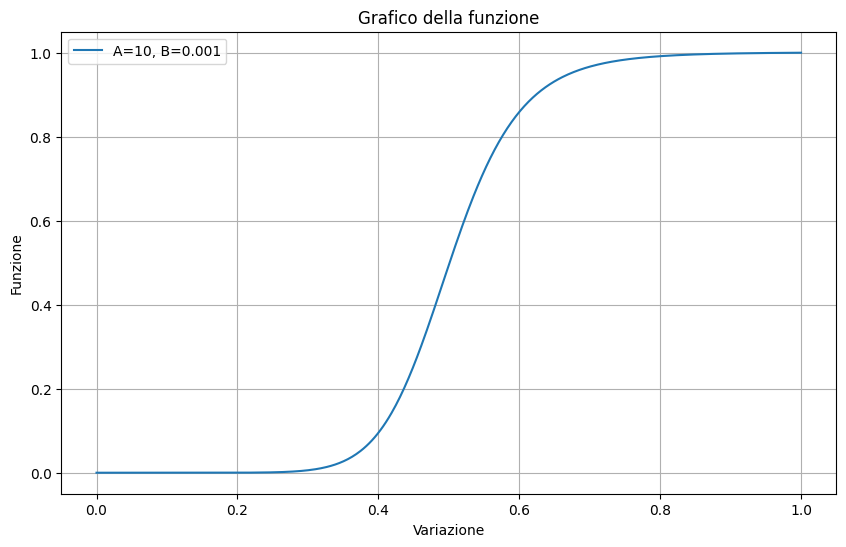

In [88]:
plot_custom_exp(A_a, B_a)

In [89]:
df_transazioni[:20]

,data,prezzo,variazione_giornaliera_prezzo_percentuale,timestamp_riferimento_discesa,prezzo_riferimento_discesa,variazione_rispetto_riferimento_discesa,timestamp_riferimento_salita,prezzo_riferimento_salita,variazione_rispetto_riferimento_salita,azione,Percentuale Liquidità Usata,Percentuale Bitcoin Usata,Percentuale Liquidità Usata rispetto riferimento,Percentuale Bitcoin Usata rispetto riferimento,quantità_euro,Bitcoin Acquistati/Venduti,Liquidità,Bitcoin,valore_totale_portafoglio
0,2021-02-02,29501.521484,6.16%,NaT,NaN,None,2021-02-01,27790.582031,6.16%,-,0,0,0,0,0,0,0,0.024781,731.090775
1,2021-02-03,31119.447266,5.48%,NaT,NaN,None,2021-02-01,27790.582031,11.98%,-,0,0,0,0,0,0,0,0.024781,771.185338
2,2021-02-04,30859.554688,-0.84%,2021-02-03,31119.447266,-0.84%,2021-02-01,27790.582031,11.04%,-,0,0,0,0,0,0,0,0.024781,764.744820
3,2021-02-05,31658.248047,2.59%,2021-02-03,31119.447266,1.73%,2021-02-01,27790.582031,13.92%,-,0,0,0,0,0,0,0,0.024781,784.537608
4,2021-02-06,32588.472656,2.94%,NaT,NaN,None,2021-02-01,27790.582031,17.26%,-,0,0,0,0,0,0,0,0.024781,807.589932
5,2021-02-07,32288.650391,-0.92%,2021-02-06,32588.472656,-0.92%,2021-02-01,27790.582031,16.19%,-,0,0,0,0,0,0,0,0.024781,800.159898
6,2021-02-08,38329.667969,18.71%,NaT,NaN,None,2021-02-01,27790.582031,37.92%,-,0,0,0,0,0,0,0,0.024781,949.865134
7,2021-02-09,38362.296875,0.09%,NaT,NaN,None,2021-02-01,27790.582031,38.04%,-,0,0,0,0,0,0,0,0.024781,950.673726
8,2021-02-10,37065.046875,-3.38%,2021-02-09,38362.296875,-3.38%,2021-02-01,27790.582031,33.37%,-,0,0,0,0,0,0,0,0.024781,918.525977
9,2021-02-11,39494.441406,6.55%,NaT,NaN,None,2021-02-01,27790.582031,42.11%,-,0,0,0,0,0,0,0,0.024781,978.729920


In [90]:
df_transazioni[df_transazioni['azione'] != '-']

,data,prezzo,variazione_giornaliera_prezzo_percentuale,timestamp_riferimento_discesa,prezzo_riferimento_discesa,variazione_rispetto_riferimento_discesa,timestamp_riferimento_salita,prezzo_riferimento_salita,variazione_rispetto_riferimento_salita,azione,Percentuale Liquidità Usata,Percentuale Bitcoin Usata,Percentuale Liquidità Usata rispetto riferimento,Percentuale Bitcoin Usata rispetto riferimento,quantità_euro,Bitcoin Acquistati/Venduti,Liquidità,Bitcoin,valore_totale_portafoglio


### Risultati

In [91]:
# Preparazione dei dati per il grafico
acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']
vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']

# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['quantità_euro'].max()
max_vendita = vendite['quantità_euro'].max()

def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if pd.notna(quantita) and max_quantita != 0 else None

# Dimensioni dei punti per acquisti e vendite
dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Funzione per formattare in modo sicuro solo i prezzi
def safe_format(value, precision=2):
    return f"{value:.{precision}f}" if pd.notna(value) else "None"

# Creazione del grafico dei prezzi con le transazioni
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(
    x=df_transazioni['data'], 
    y=df_transazioni['prezzo'],
    mode='lines',
    name='Prezzi',
    line=dict(color='blue', width=2),
    text=[
        f"Timestamp: {data}<br>Prezzo: {safe_format(p)} €<br>Variazione giornaliera: {v or 'None'}<br>Timestamp riferimento discesa: {trd or 'None'}<br>Prezzo riferimento discesa: {safe_format(prd)}<br>Variazione rispetto riferimento discesa: {vrrd or 'None'} %<br>Timestamp riferimento salita: {trs or 'None'}<br>Prezzo riferimento salita: {safe_format(prs)}<br>Variazione rispetto riferimento salita: {vrrs or 'None'} %"
        for data, p, v, trd, prd, vrrd, trs, prs, vrrs in zip(
            df_transazioni['data'], 
            df_transazioni['prezzo'], 
            df_transazioni['variazione_giornaliera_prezzo_percentuale'], 
            df_transazioni['timestamp_riferimento_discesa'], 
            df_transazioni['prezzo_riferimento_discesa'], 
            df_transazioni['variazione_rispetto_riferimento_discesa'], 
            df_transazioni['timestamp_riferimento_salita'], 
            df_transazioni['prezzo_riferimento_salita'], 
            df_transazioni['variazione_rispetto_riferimento_salita']
        )
    ],
    hoverinfo='text'
))

if len(acquisti) > 0:
    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['data'], 
        y=acquisti['prezzo'],
        mode='markers', 
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=[
            f"Timestamp: {data}<br>Prezzo: {safe_format(p)} €<br>Euro usati: {e or 'None'} €<br>Variazione giornaliera: {v or 'None'}<br>Timestamp riferimento discesa: {trd or 'None'}<br>Prezzo riferimento discesa: {safe_format(prd)}<br>Variazione rispetto riferimento discesa: {vrrd or 'None'}<br>Timestamp riferimento salita: {trs or 'None'}<br>Prezzo riferimento salita: {safe_format(prs)}<br>Variazione rispetto riferimento salita: {vrrs or 'None'}"
            for data, p, e, v, trd, prd, vrrd, trs, prs, vrrs in zip(
                acquisti['data'], 
                acquisti['prezzo'], 
                acquisti['quantità_euro'], 
                acquisti['variazione_giornaliera_prezzo_percentuale'], 
                acquisti['timestamp_riferimento_discesa'], 
                acquisti['prezzo_riferimento_discesa'], 
                acquisti['variazione_rispetto_riferimento_discesa'], 
                acquisti['timestamp_riferimento_salita'], 
                acquisti['prezzo_riferimento_salita'], 
                acquisti['variazione_rispetto_riferimento_salita']
            )
        ],
        hoverinfo='text'
    ))

if len(vendite) > 0:
    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['data'], 
        y=vendite['prezzo'],
        mode='markers', 
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=[
            f"Timestamp: {data}<br>Prezzo: {safe_format(p)} €<br>Euro usati: {e or 'None'} €<br>Variazione giornaliera: {v or 'None'}<br>Timestamp riferimento discesa: {trd or 'None'}<br>Prezzo riferimento discesa: {safe_format(prd)}<br>Variazione rispetto riferimento discesa: {vrrd or 'None'}<br>Timestamp riferimento salita: {trs or 'None'}<br>Prezzo riferimento salita: {safe_format(prs)}<br>Variazione rispetto riferimento salita: {vrrs or 'None'}"
            for data, p, e, v, trd, prd, vrrd, trs, prs, vrrs in zip(
                vendite['data'], 
                vendite['prezzo'], 
                vendite['quantità_euro'], 
                vendite['variazione_giornaliera_prezzo_percentuale'], 
                vendite['timestamp_riferimento_discesa'], 
                vendite['prezzo_riferimento_discesa'], 
                vendite['variazione_rispetto_riferimento_discesa'], 
                vendite['timestamp_riferimento_salita'], 
                vendite['prezzo_riferimento_salita'], 
                vendite['variazione_rispetto_riferimento_salita']
            )
        ],
        hoverinfo='text'
    ))


# Configurazione del layout con range slider sull'asse X
fig.update_layout(
    title='Andamento dei prezzi e transazioni',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width = 1600,
    height = 7/10 * 1600,
    
    # Aggiunta del range slider
    xaxis=dict(
        rangeslider=dict(visible=True),  # Abilita il range slider
        type="date"  # Imposta l'asse x come asse temporale
    )
)

# Mostra il grafico
fig.show()

In [92]:
dati

,Timestamp,Price,Variazione
0,2021-02-01,27790.582031,NaN
1,2021-02-02,29501.521484,1.061565
2,2021-02-03,31119.447266,1.054842
3,2021-02-04,30859.554688,0.991649
4,2021-02-05,31658.248047,1.025882
...,...,...,...
146,2021-06-27,29013.742188,1.075958
147,2021-06-28,28866.302734,0.994918
148,2021-06-29,30139.980469,1.044123
149,2021-06-30,29555.054688,0.980593


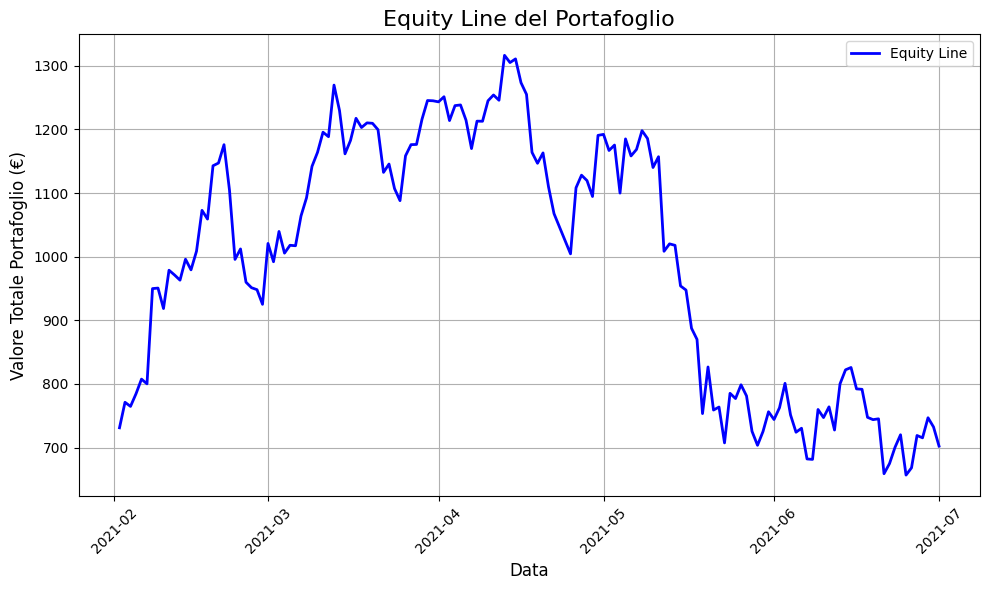

In [93]:
# Assicurati che la colonna 'Data' sia in formato datetime
df_transazioni['data'] = pd.to_datetime(df_transazioni['data'])

# Crea il plot dell'equity line
plt.figure(figsize=(10, 6))
plt.plot(df_transazioni['data'], df_transazioni['valore_totale_portafoglio'], label='Equity Line', color='b', linewidth=2)

# Aggiungi titolo e etichette agli assi
plt.title('Equity Line del Portafoglio', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valore Totale Portafoglio (€)', fontsize=12)

# Aggiungi una griglia per una migliore leggibilità
plt.grid(True)

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per migliore leggibilità
plt.tight_layout()  # Migliora il layout del grafico
plt.show()

In [94]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [95]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, dati['Price'], 0, 0, 0, 0)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

valore_iniziale = df_transazioni['valore_totale_portafoglio'].iloc[0]
valore_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
rendimento = valore_finale / valore_iniziale

print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {df_transazioni['valore_totale_portafoglio'].iloc[-1]}")

Rendimento ideale: 13.664566891503478
Portafoglio finale ideale in euro: 9410.666928779388
Rendimento del portafoglio: 0.9606763528284658
Punteggio rendimento: 7.03%
Valore finale del portafoglio in euro: 702.3416189332813


In [96]:
# periodo 1: Dicembre 2020 - Aprile 2021; periodo 2: Maggio 2021 - Luglio 2021; periodo 3: Luglio 2022 - Ottobre 2022

# Set 1:
# inverti_riferimento_acquisto = False
# inverti_riferimento_vendita = True
# acquisto_rispetto_liquidità_iniziale = True
# compra_pure = False
# vendi_pure = True
# soglia_vendita = -np.inf (nessuna soglia specifica per la vendita)
# coefficienti_acquisto = [0, 1.5] (più conservativo)
# coefficienti_vendita = [0, 1.5] (più conservativo)
# compra_solo_in_discesa = True (acquisti solo in discesa)
# vendi_solo_in_salita = True (vendite solo in salita)
# soglia_acquisto_rispetto_riferimento = 0.15 (acquisti solo se sceso almeno del 15% rispetto al riferimento)
# soglia_vendita_rispetto_riferimento = 0.1 (vendite se salito del 10% rispetto al riferimento)
# soglia_calcolo_variazioni_discesa = 0.1 (soglia per individuare trend ribassisti)
# soglia_calcolo_variazioni_salita = 0.1 (soglia per individuare trend rialzisti)

# Set 2:
# inverti_riferimento_acquisto = True
# inverti_riferimento_vendita = False
# acquisto_rispetto_liquidità_iniziale = False
# compra_pure = True
# vendi_pure = True
# soglia_vendita = 0.05 (vendite solo se sopra il 5% rispetto alla media degli acquisti)
# coefficienti_acquisto = [0, 2.5] (aggressivo, acquisti maggiori)
# coefficienti_vendita = [0, 2.5] (aggressivo, vendite maggiori)
# compra_solo_in_discesa = False (puoi comprare anche in salita)
# vendi_solo_in_salita = False (puoi vendere anche in discesa)
# soglia_acquisto_rispetto_riferimento = 0.1 (acquisti se sceso del 10%)
# soglia_vendita_rispetto_riferimento = 0.1 (vendite se salito del 10%)
# soglia_calcolo_variazioni_discesa = 0.05 (individua trend ribassisti con soglia bassa)
# soglia_calcolo_variazioni_salita = 0.05 (trend rialzisti con soglia bassa)

# Set 3:
# inverti_riferimento_acquisto = False
# inverti_riferimento_vendita = True
# acquisto_rispetto_liquidità_iniziale = True
# compra_pure = True
# vendi_pure = False
# soglia_vendita = 0.1 (vendite se sopra il 10% rispetto alla media degli acquisti)
# coefficienti_acquisto = [0, 2] (bilanciato)
# coefficienti_vendita = [0, 2] (bilanciato)
# compra_solo_in_discesa = True
# vendi_solo_in_salita = True
# soglia_acquisto_rispetto_riferimento = 0.05
# soglia_vendita_rispetto_riferimento = 0.05
# soglia_calcolo_variazioni_discesa = 0.1
# soglia_calcolo_variazioni_salita = 0.1

# Set 4:
# inverti_riferimento_acquisto = True
# inverti_riferimento_vendita = True
# acquisto_rispetto_liquidità_iniziale = False
# compra_pure = True
# vendi_pure = True
# soglia_vendita = 0.15 (vendite sopra il 15% rispetto alla media degli acquisti)
# coefficienti_acquisto = [0, 3] (speculativo, acquisti aggressivi)
# coefficienti_vendita = [0, 3] (speculativo, vendite aggressive)
# compra_solo_in_discesa = False
# vendi_solo_in_salita = False
# soglia_acquisto_rispetto_riferimento = 0.15
# soglia_vendita_rispetto_riferimento = 0.15
# soglia_calcolo_variazioni_discesa = 0.15
# soglia_calcolo_variazioni_salita = 0.15

# Risultati:
# Set 1: 33%, -2%, 7%
# Set 2: 44%, -9%, 6%
# Set 3: 88%, -5%, 6%
# Set 4: 26%, 15%, 0%

## Algoritmo con variabili dinamiche tramite grid search integrata